<a href="https://colab.research.google.com/github/emicervantes/wound_classification/blob/main/wound_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

#### Load wound data

In [98]:
X = np.load('wound_features.npy', encoding = 'bytes')
Y = np.load('wound_label.npy', encoding = 'bytes')

In [99]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30)
print(x_train.shape, y_train.shape)

(516, 50, 50, 3) (516,)


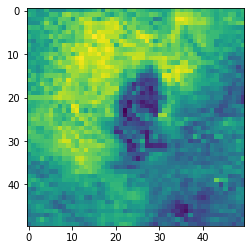

In [100]:
plt.imshow(x_train[3,:,:,0])

In [101]:
len(np.unique(Y))

6

### CNN Using Torch

In [102]:
# Check GPU avialbility
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [103]:
# Hyper parameters
num_epochs = 50
num_classes = 6
batch_size = 100
learning_rate = 1e-5

In [104]:
torch_XTr = torch.tensor(x_train)
torch_YTr = torch.tensor(y_train)
torch_XTe = torch.tensor(x_test)
torch_YTe = torch.tensor(y_test)

train = torch.utils.data.TensorDataset(torch_XTr, torch_YTr)
train_loader = torch.utils.data.DataLoader(train, batch_size= batch_size, shuffle = True)

test = torch.utils.data.TensorDataset(torch_XTe, torch_YTe)
test_loader = torch.utils.data.DataLoader(test, batch_size= batch_size, shuffle = False)



In [105]:
Xfe, Yla = next(iter(train_loader))
print(Xfe.shape, Yla.shape)


torch.Size([100, 50, 50, 3]) torch.Size([100])


In [106]:
#Xfe = torch.swapaxes(Xfe, 1,3)
#Xfe.shape

In [107]:
#plt.imshow(Xfe[100,0,:,:])

In [108]:
# CNN
print(X.shape) #Check original shape of X
class ConvNet(nn.Module):
  def __init__(self, num_classes = 6):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 4, stride = 1, padding = 2),
        nn.BatchNorm2d(64),        
        nn.Tanh(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size = 4, stride = 1, padding = 2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)  
    )
    self.fc = nn.Linear(21632, num_classes)

  def forward(self, Xfe):
    Xfe = torch.swapaxes(Xfe, 1,3)
    out = self.layer1(Xfe.float())    
    out = self.layer2(out)   
    out = out.reshape(out.size(0), -1)    
    out = self.fc(out)
    return out

(738, 50, 50, 3)


In [109]:
model = ConvNet(num_classes).to(device)
output = model(Xfe)
print(output.shape)

torch.Size([100, 6])


In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)
#test run to check loss
loss = criterion(output,Yla)
print(loss)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=21632, out_features=6, bias=True)
)
tensor(1.9329, grad_fn=<NllLossBackward0>)


In [111]:
# Train the model
total_step = len(train_loader)
#num_epochs = 5
model.train()
for epoch in range(num_epochs):    
    for i, (Xfe, Yla) in enumerate(train_loader):
        Xfe = Xfe.to(device)
        Yla = Yla.to(device)

        # Forward pass       
        outputs = model(Xfe)   

        # Calculate Loss     
        loss = criterion(outputs, Yla)

        # Backward and optimize   
        optimizer.zero_grad()     
        loss.backward()
        optimizer.step()       

        #store loss and iteration
        
        if (i+1) % 6 == 0:
            #print('Iteration: {} Loss: {} '.format(count, loss.item()))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                  .format(epoch+1, num_epochs, (i+1), total_step, loss.item()))

        #Total Iterations (if use the right # in count % # == 0) which equal 
        #total_step * epochs

Epoch [1/50], Step [6/6], Loss: 1.8500
Epoch [2/50], Step [6/6], Loss: 1.8071
Epoch [3/50], Step [6/6], Loss: 1.6813
Epoch [4/50], Step [6/6], Loss: 1.4732
Epoch [5/50], Step [6/6], Loss: 1.4140
Epoch [6/50], Step [6/6], Loss: 1.4536
Epoch [7/50], Step [6/6], Loss: 1.2313
Epoch [8/50], Step [6/6], Loss: 1.2195
Epoch [9/50], Step [6/6], Loss: 1.2740
Epoch [10/50], Step [6/6], Loss: 1.3454
Epoch [11/50], Step [6/6], Loss: 1.2146
Epoch [12/50], Step [6/6], Loss: 1.0937
Epoch [13/50], Step [6/6], Loss: 1.2832
Epoch [14/50], Step [6/6], Loss: 1.2338
Epoch [15/50], Step [6/6], Loss: 0.9846
Epoch [16/50], Step [6/6], Loss: 0.8782
Epoch [17/50], Step [6/6], Loss: 1.1433
Epoch [18/50], Step [6/6], Loss: 1.2900
Epoch [19/50], Step [6/6], Loss: 0.7881
Epoch [20/50], Step [6/6], Loss: 1.1038
Epoch [21/50], Step [6/6], Loss: 0.9929
Epoch [22/50], Step [6/6], Loss: 1.3306
Epoch [23/50], Step [6/6], Loss: 0.8635
Epoch [24/50], Step [6/6], Loss: 0.6808
Epoch [25/50], Step [6/6], Loss: 0.9646
Epoch [26

In [112]:
#Test the model
model.eval()
testmod_acc = []
with torch.no_grad():    
    for Xfe, Yla in test_loader:
        Xfe = Xfe.to(device)
        Yla = Yla.to(device)
        outputs = model(Xfe)
        _, predicted = torch.max(outputs.data, 1)
        testmod_acc.append((predicted == Yla).sum().item() / predicted.size(0))
        

    print('Test Accuracy of the model = {} %'.format(100*np.mean(testmod_acc)))

Test Accuracy of the model = 62.212121212121204 %
